In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple
from matplotlib import pyplot as plt
import tqdm
import warnings
from itertools import combinations
from geopy.distance import geodesic
plt.style.use("ggplot")

In [3]:
g = nx.read_gml("../data/clean/all_routes.gml")
all_data = pd.read_csv("../data/clean/all_data.csv")

In [4]:
all_data = pd.read_csv("../data/clean/all_data.csv")

## Functions to calculate traveltimes

In [5]:
def get_neighbors_by_type(g:nx.Graph, location:str, type:str) -> List[str]:
    neighbors = []
    if type != "City" and type != "Airport" and type != "Station":
        raise ValueError(f"Unvalid type '{type}'")
    for node in g.adj[location]:
        if g.nodes[node]["type"] == type:
             neighbors.append(node) 
    return neighbors

# calculates time from source_city -> source_airport  -> destination_airport -> destination_city
# 120min - 45min boarding time already included = 75min
def get_airplane_duration(g: nx.Graph, source_city:str, destination_city:str, airport_wait_minutes = 75) -> List[Dict[List[str], int]]:
    
    if source_city == destination_city:
        source_city.capitalize()
        destination_city.capitalize()
        warnings.warn("Source and destination city are the same")
        return 0
    
    assert g.has_node(source_city), f"{source_city} is not in network"
    assert g.has_node(destination_city), f"{destination_city} is not in network"

    source_airports = get_neighbors_by_type(g, source_city, type="Airport")
    destination_airports = get_neighbors_by_type(g, destination_city, type="Airport")
    possible_coombinations = [(source, destination)for source in source_airports for destination in destination_airports]

    durations = []
    for source_airport, destination_airport in possible_coombinations:
        route = {
            "nodes": [source_city, source_airport, destination_airport, destination_city],
            "duration": 0
        }
        route["duration"] += g[source_city][source_airport]["duration"]
        route["duration"] += g[source_airport][destination_airport]["duration"]
        route["duration"] += g[destination_airport][destination_city]["duration"]
        route["duration"] += airport_wait_minutes
        durations.append(route)
    return durations

# calculates time from source_city -> destination_city
def get_car_duration(g: nx.Graph, source_city:str, destination_city:str) -> List[Dict[List[str], int]]:
    
    if source_city == destination_city:
        source_city.capitalize()
        destination_city.capitalize()
        warnings.warn("Source and destination city are the same")
        return 0
    
    assert g.has_node(source_city), f"{source_city} is not in network"
    assert g.has_node(destination_city), f"{destination_city} is not in network"

    route = {
        "nodes": [source_city, destination_city],
        "duration": g[source_city][destination_city]["duration"]
    }
    
    return [route]

# calculates time from source_city -> source_station -> ... -> destination_station -> destination_city
def get_train_duration(g: nx.Graph, source_city:str, destination_city:str, train_wait_minutes = 10) -> List[Dict[List[str], int]]:
    def filter_train_edges(n1, n2):
        type =  g[n1][n2].get("type", "none")
        return type == "train"
    
    if source_city == destination_city:
        source_city.capitalize()
        destination_city.capitalize()
        warnings.warn("Source and destination city are the same")
        return 0
        
    assert g.has_node(source_city), f"{source_city} is not in network"
    assert g.has_node(destination_city), f"{destination_city} is not in network"

    source_airports = get_neighbors_by_type(g, source_city, type="Station")
    destination_airports = get_neighbors_by_type(g, destination_city, type="Station")
    possible_coombinations = [(source, destination)for source in source_airports for destination in destination_airports]

    durations = []
    for source_station, destination_station in possible_coombinations:
        route = {
            "nodes": [source_city],
            "duration": 0
        }
        subgraph = nx.subgraph_view(g, filter_edge=filter_train_edges)
        shortest_path = nx.shortest_path(subgraph, source=source_station, target=destination_station, weight="duration")
        route["nodes"] += shortest_path + [destination_city]
        route["duration"] = nx.path_weight(g, shortest_path, "duration")
        route["duration"] += g[source_city][source_station]["duration"]
        route["duration"] += g[destination_city][destination_station]["duration"]
        durations.append(route)  
    return durations

## Create a dataframe
To be able to analyse the data we need it in a fitting format.
Lets create a dataframe where every line is a connection between two cities. We want to include the distance and the traveltimes with car, train and plane.

We have 173 cities which means we get around 173^2/2=29929/2 < 15000 which should be no problem to process.

In [6]:
def calculate_distance(city1, city2):
    pos1 = g.nodes[city1]["pos"]
    pos2 = g.nodes[city2]["pos"]
    return geodesic(pos1, pos2).kilometers

In [7]:
# Built a dataframe
data = []

# get all citynodes
city_nodes = [node for node in g.nodes if g.nodes[node]["type"] == "City"]

# iterate through city nodes
for city1, city2 in combinations(city_nodes, 2):

    distance = calculate_distance(city1, city2)
    
    # get car_duration
    car_durations = get_car_duration(g, city1, city2)
    car_duration = car_durations[0]["duration"] if car_durations else None
    
    # get train_duration
    try:
        train_durations = get_train_duration(g, city1, city2)
        train_duration = train_durations[0]["duration"] if train_durations else None
    except nx.NetworkXNoPath:
        train_duration = None
    
    # get plane_duration
    plane_durations = get_airplane_duration(g, city1, city2)
    plane_duration = min(route["duration"] for route in plane_durations) if plane_durations else None

    data.append([city1, city2, distance, car_duration, train_duration, plane_duration])

result_df = pd.DataFrame(data, columns=["city1", "city2", "distance", "car_duration", "train_duration", "plane_duration"])


# Include Countries of city1 and city2:

country_information = all_data[["city", "Country"]]
# some cities appear more than once(because they have multiple airports)
country_information = country_information.drop_duplicates(subset='city')

result_df = result_df.merge(country_information, left_on='city1', right_on='city', how='left')
result_df = result_df.rename(columns={'Country': 'country1'})
result_df = result_df.drop('city', axis=1)

result_df = result_df.merge(country_information, left_on='city2', right_on='city', how='left')
result_df = result_df.rename(columns={'Country': 'country2'})
result_df = result_df.drop('city', axis=1)


# Add Column fastest_transportation

result_df['fastest_transportation'] = result_df[['car_duration', 'train_duration', 'plane_duration']].idxmin(axis=1)

# Map the column names to transportation modes (train, car, plane)
transportation_mapping = {'car_duration': 'car', 'train_duration': 'train', 'plane_duration': 'plane'}
result_df['fastest_transportation'] = result_df['fastest_transportation'].map(transportation_mapping)


result_df.head()

,city1,city2,distance,car_duration,train_duration,plane_duration,country1,country2,fastest_transportation
0,Graz,Innsbruck,306.702101,298,370.800000,216.000000,Austria,Austria,plane
1,Graz,Klagenfurt,98.595632,96,189.383333,192.216667,Austria,Austria,car
2,Graz,Linz,162.456030,150,197.900000,216.216667,Austria,Austria,car
3,Graz,Salzburg,197.716117,182,257.016667,211.716667,Austria,Austria,car
4,Graz,Vienna,144.572948,133,166.583333,214.833333,Austria,Austria,car


## Data Analysis

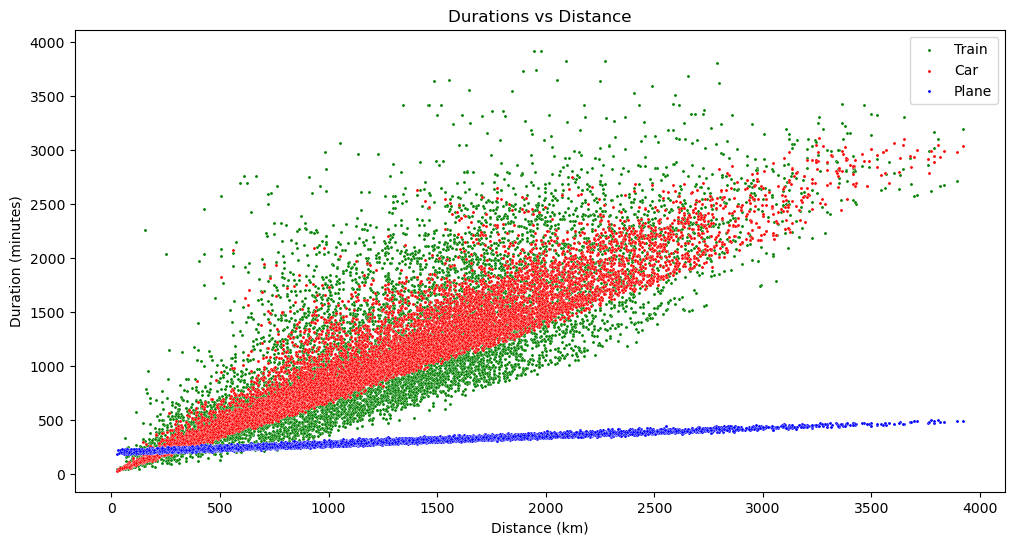

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(data=result_df, x='distance', y='train_duration', label='Train', color='green', s=5)
sns.scatterplot(data=result_df, x='distance', y='car_duration', label='Car', color='red', s=5)
sns.scatterplot(data=result_df, x='distance', y='plane_duration', label='Plane', color='blue', s=5)

plt.title('Durations vs Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Duration (minutes)')
plt.legend()
plt.show()

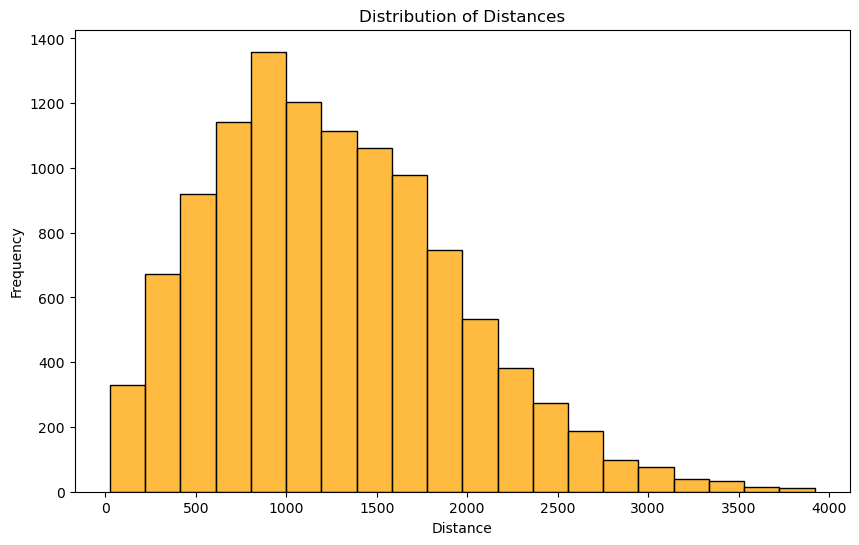

In [9]:
plt.figure(figsize=(10, 6))

sns.histplot(result_df['distance'], bins=20, color='orange', edgecolor='black')
plt.title('Distribution of Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

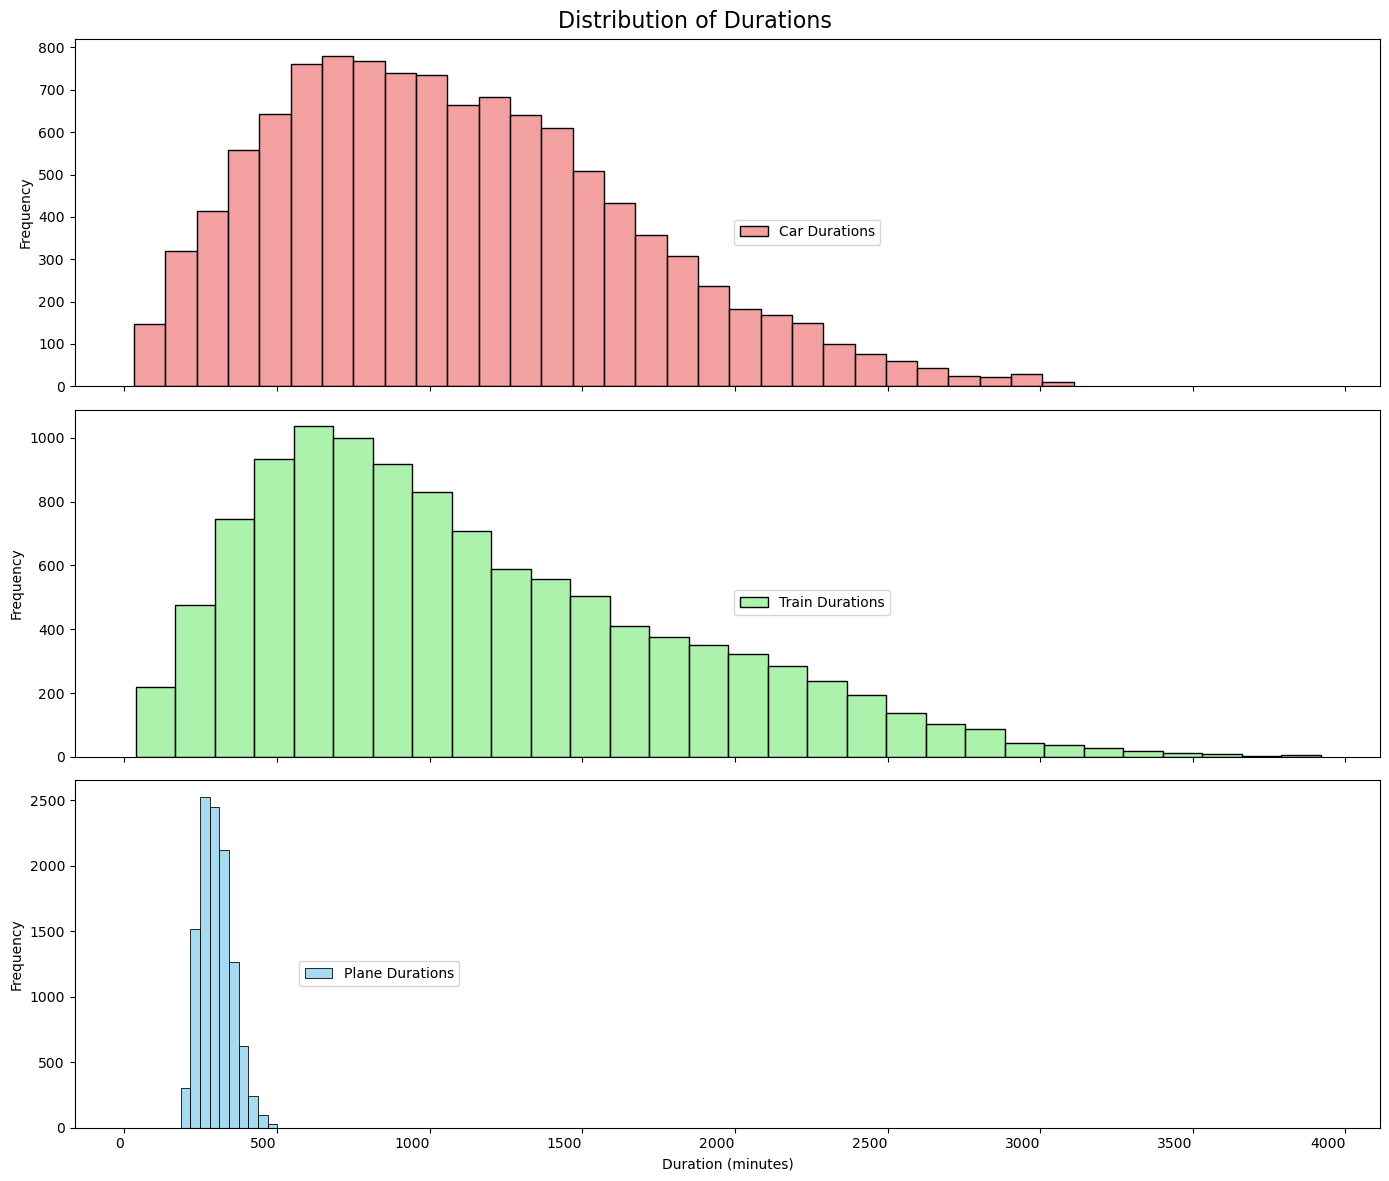

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), sharex=True)

plt.suptitle('Distribution of Durations', fontsize=16)

# Plot histogram for car durations
sns.histplot(result_df['car_duration'].dropna(), bins=30, color='lightcoral', edgecolor='black', ax=ax1)
ax1.set_xlabel('Duration (minutes)')
ax1.set_ylabel('Frequency')
ax1.legend(['Car Durations'], bbox_to_anchor=(0.5, 0.5), fancybox=True, fontsize='medium')

# Plot histogram for train durations
sns.histplot(result_df['train_duration'].dropna(), bins=30, color='lightgreen', edgecolor='black', ax=ax2)
ax2.set_xlabel('Duration (minutes)')
ax2.set_ylabel('Frequency')
ax2.legend(['Train Durations'], bbox_to_anchor=(0.5, 0.5), fancybox=True, fontsize='medium')

# Plot histogram for plane durations
sns.histplot(result_df['plane_duration'].dropna(), bins=10, color='skyblue', edgecolor='black', ax=ax3)
ax3.set_xlabel('Duration (minutes)')
ax3.set_ylabel('Frequency')
ax3.legend(['Plane Durations'], bbox_to_anchor=(0.3, 0.5), fancybox=True, fontsize='medium')

plt.tight_layout()
plt.xticks(ha='right')
plt.show()

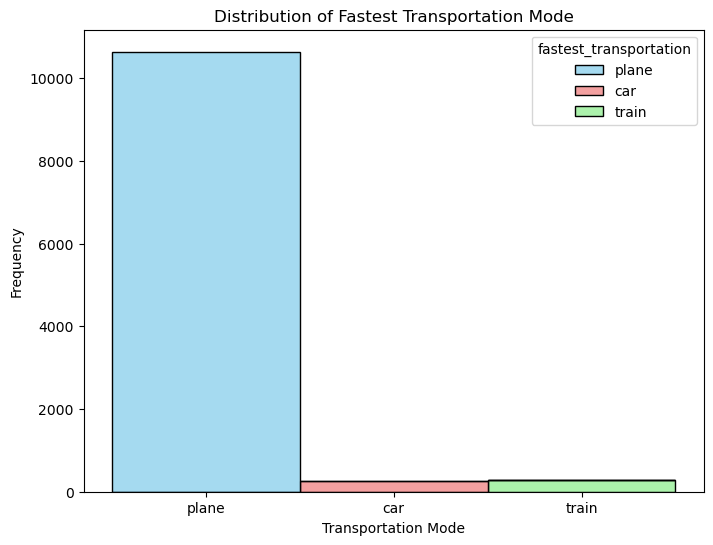

In [11]:
plt.figure(figsize=(8, 6))
sns.histplot(data=result_df, x='fastest_transportation', hue='fastest_transportation', multiple='stack',
             palette={'car': 'lightcoral', 'train': 'lightgreen', 'plane': 'skyblue'},
             edgecolor='black')

plt.title('Distribution of Fastest Transportation Mode')
plt.xlabel('Transportation Mode')
plt.ylabel('Frequency')

plt.show()

## Differences between countries:


In [12]:
country_df = all_data["Country"]
country_df = pd.DataFrame(country_df.drop_duplicates())


def get_fastest_transportation_distribution(row):
    country_input = row['Country']
    
    country_data = result_df[(result_df['country1'] == country_input) & (result_df['country2'] == country_input)]

    class_counts = country_data['fastest_transportation'].value_counts()
    class_fractions = class_counts / len(country_data)

    row['plane'] =  class_fractions.get("plane", None)
    row['train'] = class_fractions.get("train", None)
    row['car'] = class_fractions.get("car", None)
    row["total_routes"] = len(country_data)
    return row

country_df = country_df.apply(get_fastest_transportation_distribution, axis = 1)

country_df = pd.DataFrame(country_df[country_df["total_routes"] >= 10])

print(country_df)

            Country     plane     train       car  total_routes
0           Austria  0.200000  0.266667  0.533333            15
6           Belgium       NaN  0.200000  0.800000            10
20          Finland  0.533333  0.400000  0.066667            15
26           France  0.606061  0.287879  0.106061            66
41          Germany  0.522876  0.333333  0.143791           153
65            Italy  0.628571  0.247619  0.123810           210
93      Netherlands  0.100000  0.300000  0.600000            10
99           Norway  0.809524  0.047619  0.142857            21
106          Poland  0.428571  0.285714  0.285714            21
117         Romania  0.700000       NaN  0.300000            10
126           Spain  0.666667  0.217949  0.115385            78
154  United Kingdom  0.461538  0.397436  0.141026            78


## Closer look at travels under 1000km

In [13]:
filtered_df = result_df[result_df['distance']< 1000]

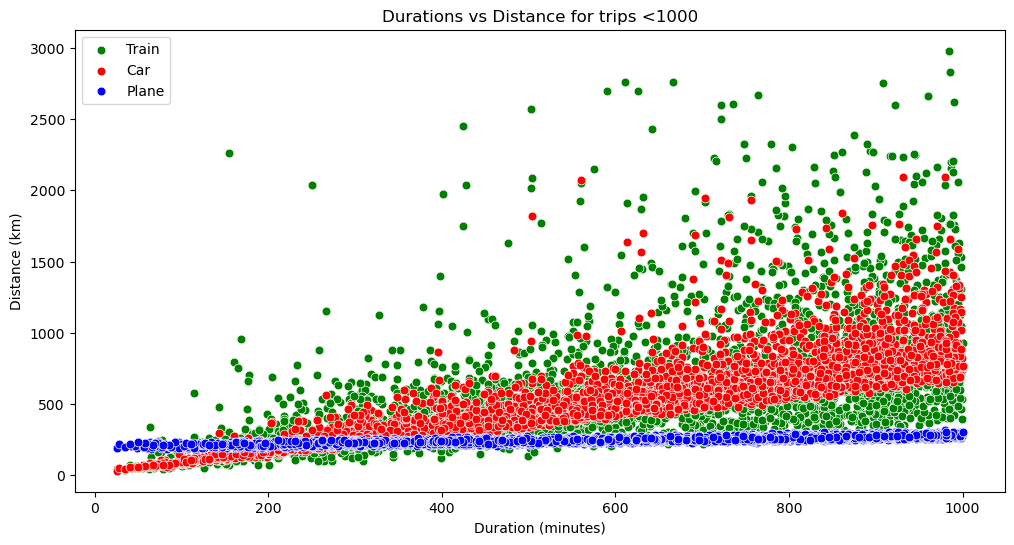

In [14]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=filtered_df, x='distance', y='train_duration', label='Train', color='green', s=40)
sns.scatterplot(data=filtered_df, x='distance', y='car_duration', label='Car', color='red', s=40)
sns.scatterplot(data=filtered_df, x='distance', y='plane_duration', label='Plane', color='blue', s=40)

plt.title('Durations vs Distance for trips <1000')
plt.xlabel('Duration (minutes)')
plt.ylabel('Distance (km)')
plt.legend()
plt.show()

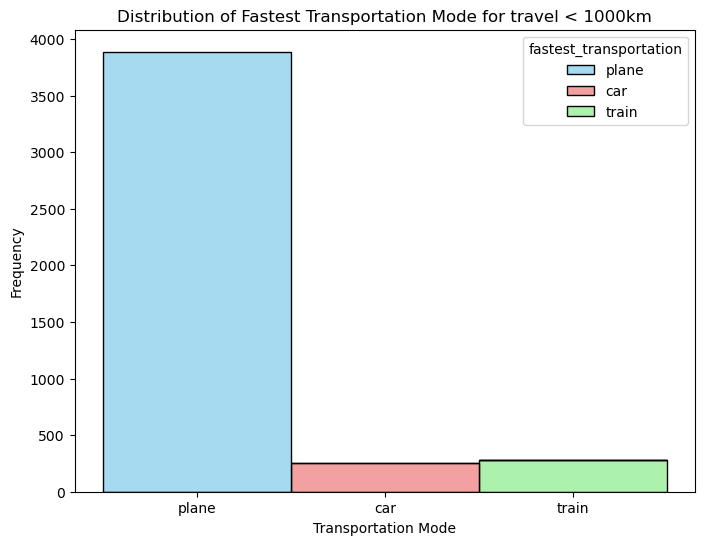

In [15]:
plt.figure(figsize=(8, 6))
sns.histplot(data=filtered_df, x='fastest_transportation', hue='fastest_transportation', multiple='stack',
             palette={'car': 'lightcoral', 'train': 'lightgreen', 'plane': 'skyblue'},
             edgecolor='black')

plt.title('Distribution of Fastest Transportation Mode for travel < 1000km')
plt.xlabel('Transportation Mode')
plt.ylabel('Frequency')

plt.show()

## Closer look at France, Belgium and the Netherlands

In [16]:
filtered_df = result_df[(result_df['country1'].isin(['France', 'Belgium', 'Netherlands'])) & 
                        (result_df['country2'].isin(['France', 'Belgium', 'Netherlands']))]

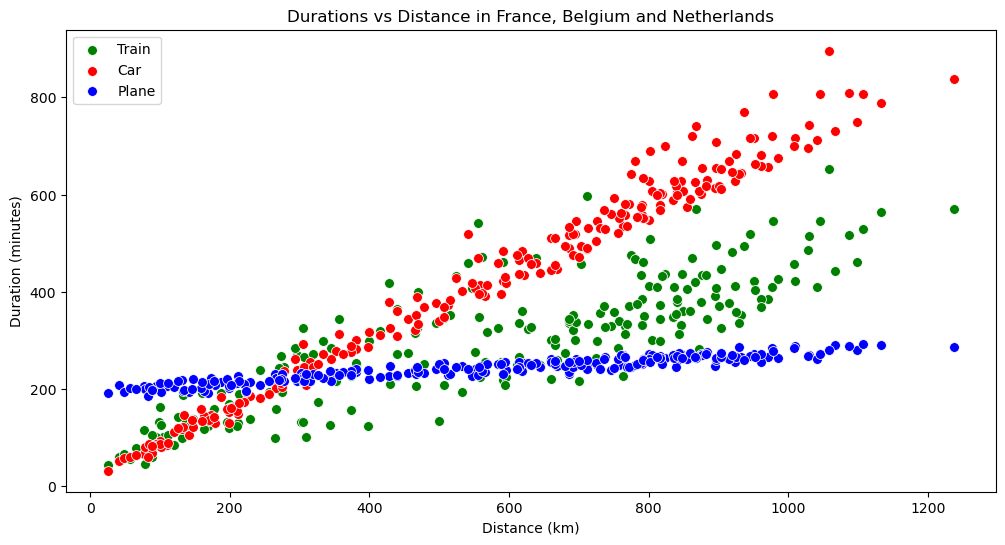

In [17]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=filtered_df, x='distance', y='train_duration', label='Train', color='green', s=50)
sns.scatterplot(data=filtered_df, x='distance', y='car_duration', label='Car', color='red', s=50)
sns.scatterplot(data=filtered_df, x='distance', y='plane_duration', label='Plane', color='blue', s=50)

plt.title('Durations vs Distance in France, Belgium and Netherlands')
plt.xlabel('Distance (km)')
plt.ylabel('Duration (minutes)')
plt.legend()
plt.show()

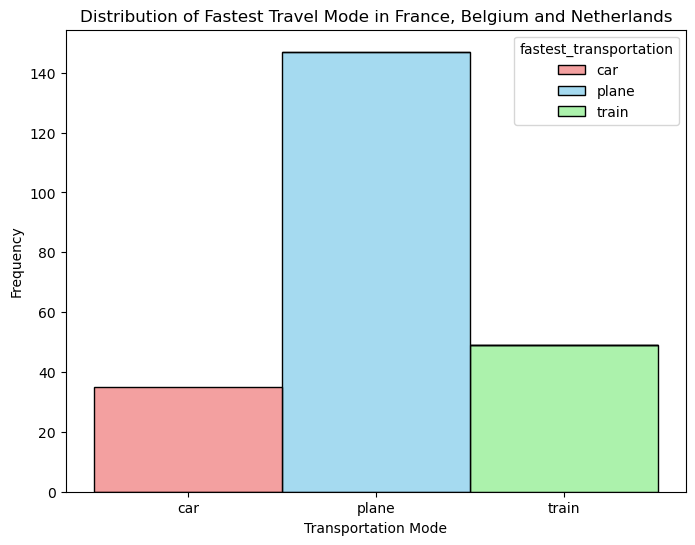

In [18]:
plt.figure(figsize=(8, 6))
sns.histplot(data=filtered_df, x='fastest_transportation', hue='fastest_transportation', multiple='stack',
             palette={'car': 'lightcoral', 'train': 'lightgreen', 'plane': 'skyblue'},
             edgecolor='black')

plt.title('Distribution of Fastest Travel Mode in France, Belgium and Netherlands')
plt.xlabel('Transportation Mode')
plt.ylabel('Frequency')

plt.show()

## Closer look at Norway, Sweden and Denmark

In [19]:
filtered_df = result_df[(result_df['country1'].isin(['Norway', 'Sweden', 'Denmark'])) & 
                        (result_df['country2'].isin(['Norway', 'Sweden', 'Denmark']))]

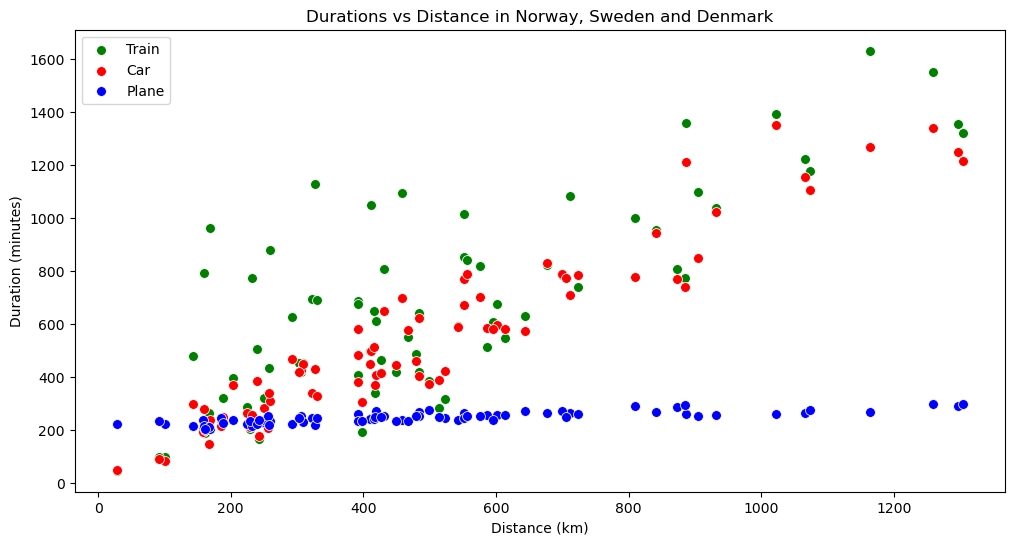

In [20]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=filtered_df, x='distance', y='train_duration', label='Train', color='green', s=50)
sns.scatterplot(data=filtered_df, x='distance', y='car_duration', label='Car', color='red', s=50)
sns.scatterplot(data=filtered_df, x='distance', y='plane_duration', label='Plane', color='blue', s=50)

plt.title('Durations vs Distance in Norway, Sweden and Denmark')
plt.xlabel('Distance (km)')
plt.ylabel('Duration (minutes)')
plt.legend()
plt.show()

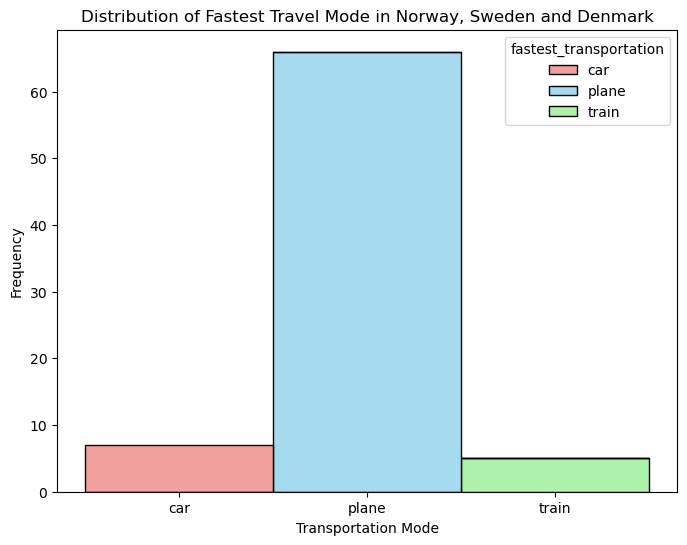

In [21]:
plt.figure(figsize=(8, 6))
sns.histplot(data=filtered_df, x='fastest_transportation', hue='fastest_transportation', multiple='stack',
             palette={'car': 'lightcoral', 'train': 'lightgreen', 'plane': 'skyblue'},
             edgecolor='black')

plt.title('Distribution of Fastest Travel Mode in Norway, Sweden and Denmark')
plt.xlabel('Transportation Mode')
plt.ylabel('Frequency')

plt.show()

## A closer look at national travel to Paris

In [22]:
filtered_df = result_df[((result_df['city1']=="Paris") & (result_df['country2']=="France"))|
                        ((result_df['city2']=="Paris") & (result_df['country1']=="France"))]

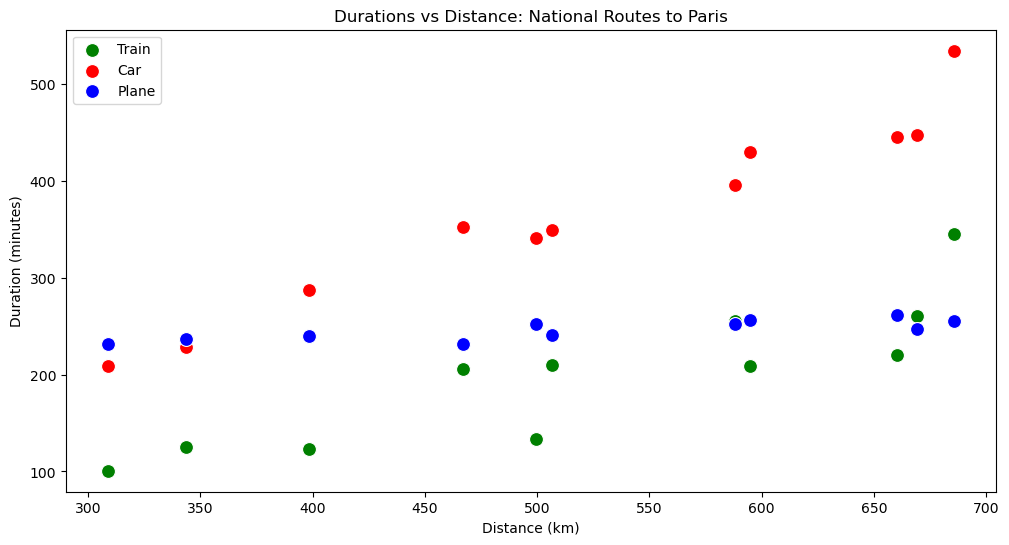

In [23]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=filtered_df, x='distance', y='train_duration', label='Train', color='green', s=100)
sns.scatterplot(data=filtered_df, x='distance', y='car_duration', label='Car', color='red', s=100)
sns.scatterplot(data=filtered_df, x='distance', y='plane_duration',label='Plane', color='blue', s=100)

plt.title('Durations vs Distance: National Routes to Paris')
plt.xlabel('Distance (km)')
plt.ylabel('Duration (minutes)')
plt.legend()
plt.show()

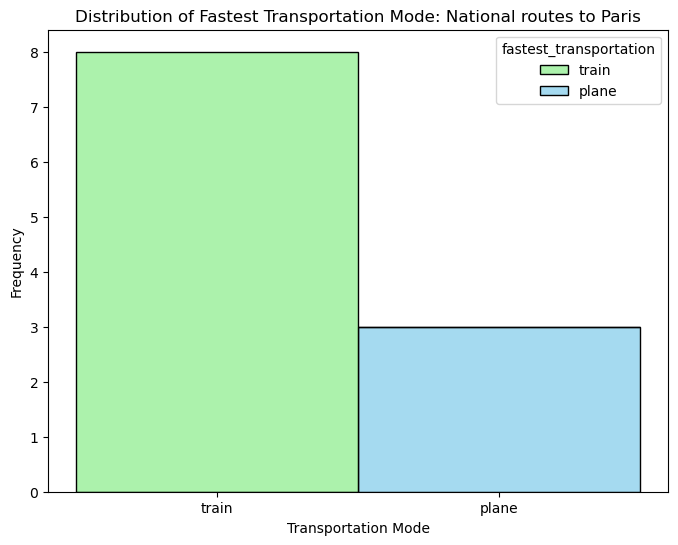

In [24]:
plt.figure(figsize=(8, 6))
sns.histplot(data=filtered_df, x='fastest_transportation', hue='fastest_transportation', multiple='stack',
             palette={'car': 'lightcoral', 'train': 'lightgreen', 'plane': 'skyblue'},
             edgecolor='black')

plt.title('Distribution of Fastest Transportation Mode: National routes to Paris')
plt.xlabel('Transportation Mode')
plt.ylabel('Frequency')

plt.show()

## How much faster is it to travel by plane than car/train

In [25]:
result_df["duration_plane_minus_car"] = result_df["plane_duration"] - result_df["car_duration"]
result_df["duration_plane_minus_train"] = result_df["plane_duration"] - result_df["train_duration"]

In [26]:
filtered_df200 = result_df[result_df['distance']< 200]
filtered_df200_500 = result_df[(result_df['distance']>= 200) & (result_df['distance']<500)]
filtered_df500_1000 = result_df[(result_df['distance']>= 500) & (result_df['distance']<1000)]
filtered_df1000 = result_df[result_df['distance']>= 1000]

filtered_dfs = [result_df, filtered_df200, filtered_df200_500, filtered_df500_1000, filtered_df1000]
filtered_df_names = ['result_df', 'filtered_df200', 'filtered_df200_500', 'filtered_df500_1000', 'filtered_df1000']

mean_results_df = pd.DataFrame(columns=['duration_plane_minus_car', 'duration_plane_minus_train'])

for df, df_name in zip(filtered_dfs, filtered_df_names):
    mean_results_df.loc[df_name] = df[['duration_plane_minus_car', 'duration_plane_minus_train']].mean()

print(mean_results_df)

                     duration_plane_minus_car  duration_plane_minus_train
result_df                         -785.572453                 -834.270911
filtered_df200                      81.196981                   34.286836
filtered_df200_500                 -99.116621                 -151.949651
filtered_df500_1000               -422.127201                 -476.208732
filtered_df1000                  -1096.906575                -1142.572264
